# Load gaussian model

In [1]:
import os
import sys
import json
import torch
import numpy as np
import torchvision
from pathlib import Path
from types import SimpleNamespace
from gaussian_renderer import render
from gaussian_renderer import GaussianModel
from utils.graphics_utils import focal2fov, fov2focal
from utils.camera_utils import Camera
from scene.dataset_readers import CameraInfo

def load_model(model_path, sh_degree=3):
    with torch.no_grad():
        gaussians  = GaussianModel(sh_degree)
        gaussians.load_ply(model_path)
        print(f"gaussain model has been load from {model_path}")
        return gaussians


def load_camera_infos(camera_path):
    with open(camera_path) as f:
        cameras_data = json.load(f)

    cameras = []
    for cam_idx in range(len(cameras_data)):
        rotation = np.array(cameras_data[cam_idx]['rotation'])
        position = np.array(cameras_data[cam_idx]['position'])
        height = cameras_data[cam_idx]['height']
        width  = cameras_data[cam_idx]['width']
        focalx = cameras_data[cam_idx]['fx']
        focaly = cameras_data[cam_idx]['fy']
        id     = cameras_data[cam_idx]['id']
        name   = cameras_data[cam_idx]['img_name']

        C2W = np.zeros((4,4))
        C2W[:3, :3] = rotation
        C2W[:3,  3] = position
        C2W[3,   3] = 1
        W2C = np.linalg.inv(C2W)
        T = W2C[:3, 3]
        R = W2C[:3, :3].transpose()
        
        fov_y = focal2fov(focaly, height)
        fov_x = focal2fov(focalx, width)
        image = None

        # CameraInfo 和 Camera的输入的R和T需要特别注意，R为camera to world，T为world to camera
        # camera = Camera(colmap_id=id, R=R, T=T, FoVx=fov_x, FoVy=fov_y, image=image, gt_alpha_mask=None,
        #                 image_name=name, uid=id)
        camera = CameraInfo(uid=cam_idx, R=R, T=T, FovY=fov_y, FovX=fov_x, image=image,
                              image_path=None, image_name=name, width=width, height=height)
        cameras.append(camera)
    print(f"{len(cameras)} cameras have been loaded from {camera_path}")
    return cameras

def render_image(model, camera, image_save_path=None, white_backgrund=False):
    with torch.no_grad():
        pipeline   = {"debug":False, "compute_cov3D_python":False, "convert_SHs_python":False, "depth_ratio":0}
        pipeline   = SimpleNamespace(**pipeline)
        background = torch.tensor([0, 0, 0] if not white_backgrund else [1,1,1], dtype=torch.float32, device="cuda")
        rendering = render(camera, model, pipeline, background)["render"]
        if image_save_path is not None:
            torchvision.utils.save_image(rendering,image_save_path)
    return rendering.permute(1,2,0).cpu().numpy()
camera_path = "output/garden/cameras.json"
model_path = "output/garden/point_cloud/iteration_30000/point_cloud.ply"
model = load_model(model_path, sh_degree=3)
cameras_infos = load_camera_infos(camera_path)



gaussain model has been load from output/garden/point_cloud/iteration_30000/point_cloud.ply
185 cameras have been loaded from output/garden/cameras.json


# render one image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


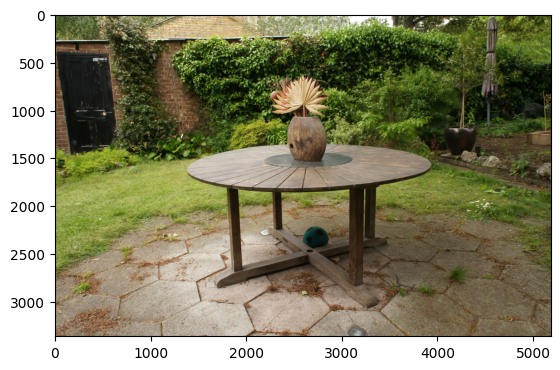

In [2]:
import matplotlib.pyplot as plt
cam_info = cameras_infos[0]
camera = Camera(colmap_id=cam_info.uid, R=cam_info.R, T=cam_info.T, 
                FoVx=cam_info.FovX, FoVy=cam_info.FovY, 
                image=torch.zeros((3,cam_info.height, cam_info.width)), gt_alpha_mask=None,
                image_name=cam_info.image_name, uid=id)
origianl_image = render_image(model, camera, white_backgrund=False) # hwc
plt.imshow(origianl_image)
plt.draw()

# Visualize in open3d

In [24]:
import math
import torch
import numpy as np
import open3d as o3d
from tqdm import tqdm

def create_camera_frustum(pose, fov_rad, aspect, near, far):
    h_near = 2 * math.tan(fov_rad / 2) * near
    w_near = h_near * aspect
    h_far = 2 * math.tan(fov_rad / 2) * far
    w_far = h_far * aspect
    
    # 定义视锥在相机坐标系中的8个角点
    # 相机位于原点，朝向正Z方向
    points_camera = np.array([
        [0, 0, 0],  # 相机位置
        
        [-w_near/2,  h_near/2, near],
        [ w_near/2,  h_near/2, near],
        [ w_near/2, -h_near/2, near],
        [-w_near/2, -h_near/2, near],
        
        [-w_far/2,  h_far/2, far],
        [ w_far/2,  h_far/2, far],
        [ w_far/2, -h_far/2, far],
        [-w_far/2, -h_far/2, far],
    ], dtype=float)  # 确保数组为浮点类型

    # 将视锥的点从相机坐标系转换到世界坐标系
    # 使用位姿矩阵的逆（从相机到世界）
    pose_inv = np.linalg.inv(pose)
    points_world_homog = pose_inv @ np.hstack((points_camera, np.ones((points_camera.shape[0], 1)))).T
    points_world = points_world_homog[:3].T
    
    # 定义视锥的边（线段连接）
    lines = [
        [0,1], [0,2], [0,3], [0,4],  # 从相机到近裁剪面的四个角点
        [1,2], [2,3], [3,4], [4,1],  # 近裁剪面的边界
        [1,5], [2,6], [3,7], [4,8],  # 连接近裁剪面和远裁剪面的边
        [5,6], [6,7], [7,8], [8,5]   # 远裁剪面的边界
    ]
    
    # 定义视锥边的颜色，例如蓝色
    colors = [[0, 0, 1] for _ in lines]
    
    # 创建视锥的 LineSet
    frustum = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(points_world),
        lines=o3d.utility.Vector2iVector(lines)
    )
    frustum.colors = o3d.utility.Vector3dVector(colors)
    
    return frustum

@torch.no_grad()
def visualize_camera_and_gaussians(cameras, model):
    points = model.get_xyz.detach().cpu().numpy()
    colors = model._features_dc.detach().cpu().numpy().reshape(points.shape[0], -1)
    colors = colors * 0.28209479177387814 + 0.5
    print("model has {} gaussians".format(len(points)))
    print("points min {}, max {}, center {}".format(points.min(0), points.max(0), points.mean(0)))

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    base_point = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0,0,0])
    geometries = [pcd]

    for camera in tqdm(cameras):
        intrinsic = o3d.camera.PinholeCameraIntrinsic(
            width=camera.image_width,
            height=camera.image_height,
            fx=fov2focal(camera.FoVx, camera.image_width),
            fy=fov2focal(camera.FoVy, camera.image_height),
            cx=camera.image_width/2,
            cy=camera.image_height/2
        )
        
        position = np.array(camera.T)               # W2C
        rotation = np.array(camera.R).transpose()   # W2C
        W2C = np.eye(4)
        W2C[:3, :3] = rotation
        W2C[:3,  3] = position
        C2W = np.linalg.inv(W2C)

        camera_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0,0,0])
        camera_frame.transform(C2W)
        
        frustum = o3d.geometry.LineSet.create_camera_visualization(
            intrinsic.width, intrinsic.height, intrinsic.intrinsic_matrix, W2C, scale=2.0
        )
        # frustum = create_camera_frustum(W2C, camera.FoVy, camera.image_width / camera.image_height, 0.1, 2)

        geometries.append(camera_frame)
        geometries.append(frustum)

    o3d.visualization.draw_geometries(geometries, point_show_normal=True, height=1080, width=1920)
cameras = [Camera(colmap_id=cam_info.uid, R=cam_info.R, T=cam_info.T, 
                FoVx=cam_info.FovX, FoVy=cam_info.FovY, 
                image=torch.zeros((3,cam_info.height, cam_info.width)), gt_alpha_mask=None,
                image_name=cam_info.image_name, uid=id) for cam_info in cameras_infos]
# visualize_camera_and_gaussians(cameras, model)
visualize_camera_and_gaussians([cameras[0]], model)

model has 1197714 gaussians
points min [ -84.670006  -30.110386 -104.25075 ], max [53.83034  14.157486 59.29606 ], center [-2.2547452 -2.7693694 -0.9012272]


100%|██████████| 1/1 [00:00<00:00, 444.12it/s]


# Edit: Rotate gaussain model

### Define some function to rotate gaussian model

In [4]:
import torch
import einops
from e3nn import o3
from einops import einsum
from scipy.spatial.transform import Rotation
from utils.general_utils import build_rotation

@torch.no_grad()
def rotate_xyz(gaussians, rotmat):
    new_xyz = gaussians.get_xyz
    mean_xyz = torch.mean(new_xyz,0)
    new_xyz = new_xyz - mean_xyz
    new_xyz = new_xyz @ rotmat.T
    gaussians._xyz = new_xyz + mean_xyz

@torch.no_grad()
def rotate_rot(gaussians, rotmat):
    new_rotation = build_rotation(gaussians._rotation)
    new_rotation = rotmat @ new_rotation
    new_quat = np.array(Rotation.from_matrix(new_rotation.detach().cpu().numpy()).as_quat())
    new_quat[:, [0,1,2,3]] = new_quat[:, [3,0,1,2]] # xyzw -> wxyz
    gaussians._rotation = torch.from_numpy(new_quat).to(gaussians._rotation.device).float()


@torch.no_grad()
def rotate_shs(gaussians, rotmat):
    # reference: https://github.com/graphdeco-inria/gaussian-splatting/issues/176#issuecomment-2147223570
    shs_feat = gaussians._features_rest
    ## rotate shs
    P = np.array([[0, 0, 1], [1, 0, 0], [0, 1, 0]], dtype=np.float32) # switch axes: yzx -> xyz
    permuted_rotmat = np.linalg.inv(P) @ rotmat.to('cpu').numpy() @ P
    rot_angles = o3._rotation.matrix_to_angles(torch.from_numpy(permuted_rotmat))

    # Construction coefficient
    D_1 = o3.wigner_D(1, rot_angles[0], - rot_angles[1], rot_angles[2]).to(shs_feat.device).float()
    D_2 = o3.wigner_D(2, rot_angles[0], - rot_angles[1], rot_angles[2]).to(shs_feat.device).float()
    D_3 = o3.wigner_D(3, rot_angles[0], - rot_angles[1], rot_angles[2]).to(shs_feat.device).float()

    #rotation of the shs features
    one_degree_shs = shs_feat[:, 0:3]
    one_degree_shs = einops.rearrange(one_degree_shs, 'n shs_num rgb -> n rgb shs_num')
    one_degree_shs = einsum(
            D_1,
            one_degree_shs,
            "... i j, ... j -> ... i",
        )
    one_degree_shs = einops.rearrange(one_degree_shs, 'n rgb shs_num -> n shs_num rgb')
    shs_feat[:, 0:3] = one_degree_shs

    two_degree_shs = shs_feat[:, 3:8]
    two_degree_shs = einops.rearrange(two_degree_shs, 'n shs_num rgb -> n rgb shs_num')
    two_degree_shs = einsum(
            D_2,
            two_degree_shs,
            "... i j, ... j -> ... i",
        )
    two_degree_shs = einops.rearrange(two_degree_shs, 'n rgb shs_num -> n shs_num rgb')
    shs_feat[:, 3:8] = two_degree_shs

    three_degree_shs = shs_feat[:, 8:15]
    three_degree_shs = einops.rearrange(three_degree_shs, 'n shs_num rgb -> n rgb shs_num')
    three_degree_shs = einsum(
            D_3,
            three_degree_shs,
            "... i j, ... j -> ... i",
        )
    three_degree_shs = einops.rearrange(three_degree_shs, 'n rgb shs_num -> n shs_num rgb')
    shs_feat[:, 8:15] = three_degree_shs

    gaussians._features_rest = shs_feat.float()

def rotate_camera(cam_position, cam_rotation, obj_position, rotmat):
    translated_position = cam_position - obj_position
    translated_position = translated_position @ rotmat.T
    new_cam_position = translated_position + obj_position
    new_cam_rotation = rotmat @ cam_rotation
    return new_cam_position, new_cam_rotation


def rotate_o3dmesh(mesh_path, mesh_save_path, rotation_matrix, model_center):
    import open3d as o3d
    mesh_dir = os.path.dirname(mesh_path)
    mesh = o3d.io.read_triangle_mesh(mesh_path)
    assert rotation_matrix.shape == (3, 3), "Rotation matrix must be 3x3."
    vertices = np.asarray(mesh.vertices)
    vertices -= model_center
    rotated_vertices = np.dot(vertices, rotation_matrix.T)
    rotated_vertices += model_center
    mesh.vertices = o3d.utility.Vector3dVector(rotated_vertices)
    o3d.io.write_triangle_mesh(mesh_save_path, mesh)


## 1. rotate gaussians

185 cameras have been loaded from output/garden_aligned_xy/cameras.json


WARNING - 2024-12-26 21:09:35,226 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


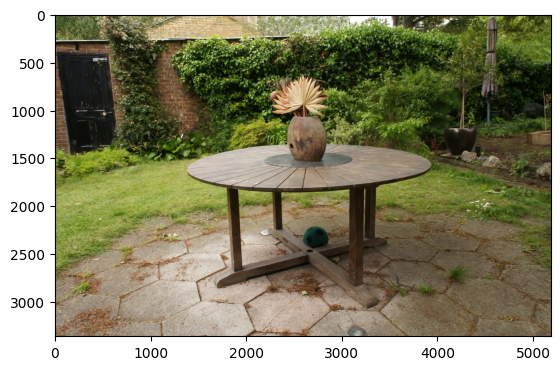

In [6]:

import numpy as np
from copy import deepcopy
from scipy.spatial.transform import Rotation

angle_degrees = -120
angle_radians = np.deg2rad(angle_degrees)
rotation = Rotation.from_euler('x', angle_radians)
rotation = rotation.as_matrix() 
# rotation = Rotation.from_euler('y', np.deg2rad(-3)).as_matrix() @ rotation
# rotation = Rotation.from_euler('x', np.deg2rad(-10)).as_matrix() @ rotation
rotmat = torch.from_numpy(rotation).to(model.get_xyz.device).float()

rotated_model = deepcopy(model)
rotate_xyz(rotated_model, rotmat)
rotate_rot(rotated_model, rotmat)
rotate_shs(rotated_model, rotmat)

rotate_gaussians_image = render_image(rotated_model, camera, white_backgrund=False) # hwc
# plt.imshow(rotate_gaussians_image)
# plt.draw()

# cameras = [camera]
# visualize_camera_and_gaussians(cameras, rotated_model)
rotated_model.save_ply("output/garden_aligned_xy/point_cloud/iteration_30000/point_cloud.ply")
mesh_path = "output/garden/train/ours_30000/fuse_unbounded_post.ply"
mesh_save_path = "output/garden_aligned_xy/train/ours_30000/aligned_xy_mesh.ply"
rotate_o3dmesh(mesh_path, mesh_save_path, rotation, model_center=torch.mean(model.get_xyz, dim=0).detach().cpu().numpy())
with open(camera_path) as f:
    cameras_data = json.load(f)
    model_center = torch.mean(model.get_xyz, dim=0).detach().cpu().numpy()
    for cam_idx in range(len(cameras_data)):
        cam_position = np.array(cameras_data[cam_idx]["position"])
        cam_rotation = np.array(cameras_data[cam_idx]["rotation"])
        new_cam_position, new_cam_rotation = rotate_camera(cam_position, cam_rotation, model_center, rotation)
        cameras_data[cam_idx]["position"] = new_cam_position.tolist()
        cameras_data[cam_idx]["rotation"] = new_cam_rotation.tolist()

with open("output/garden_aligned_xy/cameras.json", 'w') as f:
    json.dump(cameras_data, f)
new_cameras_infos = load_camera_infos("output/garden_aligned_xy/cameras.json")
new_cam_info = new_cameras_infos[0]
new_camera = Camera(colmap_id=new_cam_info.uid, R=new_cam_info.R, T=new_cam_info.T, 
                FoVx=new_cam_info.FovX, FoVy=new_cam_info.FovY, 
                image=torch.zeros((3,new_cam_info.height, new_cam_info.width)), gt_alpha_mask=None,
                image_name=new_cam_info.image_name, uid=id)
new_image = render_image(rotated_model, new_camera, white_backgrund=False) # hwc
plt.imshow(new_image)
plt.draw()
# cameras = [new_camera]
# visualize_camera_and_gaussians(cameras, rotated_model)

## 2. rotate camera

WARNING - 2024-12-26 19:56:24,367 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


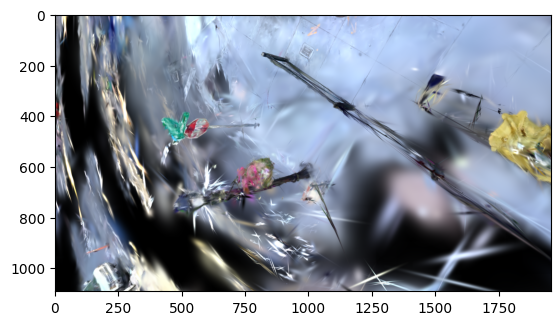

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

def rotate_camera(cam_position, cam_rotation, obj_position, rotmat):
    translated_position = cam_position - obj_position
    translated_position = translated_position @ rotmat.T
    new_cam_position = translated_position + obj_position
    new_cam_rotation = rotmat @ cam_rotation
    return new_cam_position, new_cam_rotation


angle_degrees = 90
angle_radians = np.deg2rad(angle_degrees)
rotation = Rotation.from_euler('x', angle_radians)
rotmat = np.linalg.inv(rotation.as_matrix())
model_center = torch.mean(model.get_xyz, dim=0).detach().cpu().numpy()
cam_w2c = np.eye(4)
cam_w2c[:3, :3] = cam_info.R.transpose()
cam_w2c[:3,  3] = cam_info.T
cam_c2w = np.linalg.inv(cam_w2c)
cam_position = cam_c2w[:3,  3]
cam_rotation = cam_c2w[:3, :3]

rotated_position, rotated_rotation = rotate_camera(cam_position, cam_rotation, model_center, rotmat)
rotated_cam_c2w = np.eye(4)
rotated_cam_c2w[:3, :3] = rotated_rotation
rotated_cam_c2w[:3,  3] = rotated_position
rotated_cam_w2c = np.linalg.inv(rotated_cam_c2w)

# Camera类输入参数的R和T需要特别注意，R为camera to world的旋转矩阵，T为world to camera的平移向量, 3DGS原始代码就是这样定义的
rotated_camera = Camera(colmap_id=cam_info.uid, R=rotated_rotation, T=rotated_cam_w2c[:3,  3], 
                FoVx=cam_info.FovX, FoVy=cam_info.FovY, 
                image=torch.zeros((3,cam_info.height, cam_info.width)), gt_alpha_mask=None,
                image_name=cam_info.image_name, uid=id)

rotate_camera_image = render_image(model, rotated_camera, white_backgrund=False) # hwc
plt.imshow(rotate_camera_image)
plt.draw()
# cameras = [rotated_camera]
# visualize_camera_and_gaussians(cameras, model)







In [11]:
import numpy as np

def PSNR(img1, img2):
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)

    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')

    pixel_max = 1
    psnr = 20 * np.log10(pixel_max / np.sqrt(mse))
    return psnr

# print("all close: ", np.allclose(rotate_gaussians_image, rotate_camera_image, atol=1e-6))
print("MSE:  ", np.abs(rotate_gaussians_image-rotate_camera_image).mean())
print("PSNR: ", PSNR(rotate_gaussians_image, rotate_camera_image))


MSE:   7.633272e-07
PSNR:  99.72171318040537


# Edit: Tranlate gaussian model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


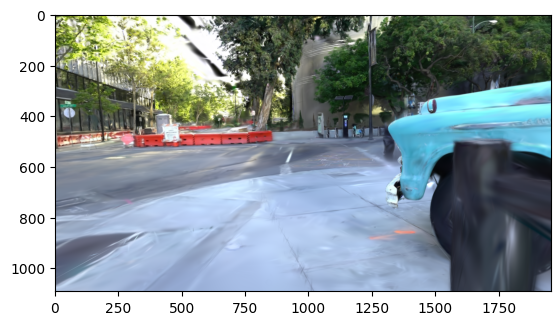

In [15]:
import torch
from copy import deepcopy

@torch.no_grad()
def translate_gaussians(gaussians, translate):
    new_xyz = gaussians.get_xyz
    new_xyz = new_xyz + translate[None]
    gaussians._xyz = new_xyz

translate = torch.tensor([5,0,0], device=model.get_xyz.device)
translated_model = deepcopy(model) 
translate_gaussians(translated_model, translate)

translated_image = render_image(translated_model, camera, white_backgrund=False) # hwc
plt.imshow(translated_image)
plt.draw()

# Edit: Scale gaussian model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


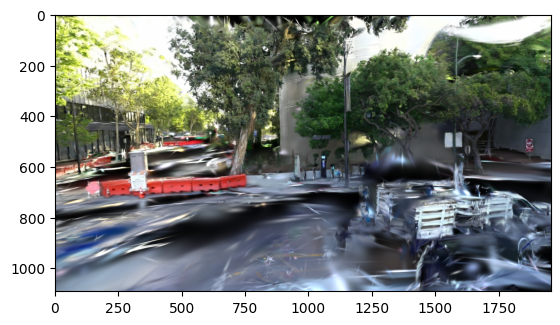

In [ ]:
import torch
from copy import deepcopy

@torch.no_grad()
def scale_gaussians(gaussians, scale):
    # scale gaussians potsition
    new_xyz = gaussians.get_xyz
    mean_xyz = torch.mean(new_xyz,0)
    new_xyz = new_xyz - mean_xyz
    new_xyz = new_xyz * scale[None]
    gaussians._xyz = new_xyz + mean_xyz

    # scale gaussians scale
    new_scaling = torch.exp(gaussians._scaling) * scale[:2][None]
    gaussians._scaling = torch.log(new_scaling)
    
scale = torch.tensor([2,2,2], device=model.get_xyz.device)
scaled_model = deepcopy(model) 
scale_gaussians(scaled_model, scale)
scaled_model.save_ply(path="./output.ply")

scaled_image = render_image(scaled_model, camera, white_backgrund=False) # hwc
plt.imshow(scaled_image)
plt.draw()